In [1]:
import os, sys
sys.path.insert(0, os.path.dirname(os.getcwd())) 

In [35]:
import cache_magic
import hashlib
from typing import List, Union, Dict, Any
from tqdm import tqdm
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
import lightgbm as lgbm

from ml_trader.utils import load_config
from ml_trader.data_loaders.quandl import (quandl_base_to_df,
                                           quandl_quarterly_to_df,
                                           quandl_daily_to_df,
                                           quandl_commodity_to_df)
from ml_trader.model import LogExpModel, EnsembleModel

In [3]:
config = load_config()
tickers = config["tickers_quandl"]
len(tickers), tickers[:10]

(1492,
 ['ZI', 'HALO', 'WGO', 'VIPS', 'OSK', 'MAC', 'BJRI', 'HCCI', 'HSC', 'ANAB'])

## Base Features

In [4]:
df_base = quandl_base_to_df(
    filepath=os.path.dirname(os.getcwd()) + '/datasets/quandl/SHARADAR_TICKERS_6cc728d11002ab9cb99aa8654a6b9f4e.csv',
    tickers=tickers,
)
df_base.head()

,table,permaticker,ticker,name,exchange,isdelisted,category,cusips,siccode,sicsector,...,currency,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite
0,SF1,196290,A,Agilent Technologies Inc,NYSE,N,Domestic Common Stock,00846U101,3826.0,Manufacturing,...,USD,California; U.S.A,2021-06-01,2014-09-26,1999-11-18,2021-07-21,1997-06-30,2021-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.agilent.com
1,SF1,124392,AA,Alcoa Corp,NYSE,N,Domestic Common Stock,013872106,3334.0,Manufacturing,...,USD,Pennsylvania; U.S.A,2021-05-05,2016-11-01,2016-11-01,2021-07-21,2014-12-31,2021-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.alcoa.com
2,SF1,199960,AAL,American Airlines Group Inc,NASDAQ,N,Domestic Common Stock,02376R102,4512.0,Transportation Communications Electric Gas And...,...,USD,Texas; U.S.A,2021-04-22,2015-04-14,2013-12-09,2021-07-21,2012-12-31,2021-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.aa.com
3,SF1,632687,AAN,Aaron's Company Inc,NYSE,N,Domestic Common Stock,00258W108,7359.0,Services,...,USD,Georgia; U.S.A,2021-05-02,2020-12-02,2020-11-25,2021-07-21,2018-12-31,2021-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN
4,SF1,198259,AAON,Aaon Inc,NASDAQ,N,Domestic Common Stock,000360206,3585.0,Manufacturing,...,USD,Oklahoma; U.S.A,2021-05-06,2014-10-14,1992-12-16,2021-07-21,1996-12-31,2021-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.aaon.com


In [5]:
def int_hash_of_str(text: str) -> int:
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16)

int_hash_of_str('Some text')

2645911594

In [6]:
class RobustHashingEncoder:
    def transform(self, vals: List[str]):
        result = [int_hash_of_str(str(x)) for x in vals]
        return result

RobustHashingEncoder().transform(['hey', 'John'])

[1616376124, 1631623841]

In [7]:
len(df_base['sector'].unique())

11

In [8]:
len(df_base['sicindustry'].unique())

307

In [9]:
for col in ['sector', 'sicindustry']:
    df_base[col] = df_base[col].fillna('None')
    df_base[col] = RobustHashingEncoder().transform(df_base[col])

df_base_p = df_base[['ticker', 'sector', 'sicindustry']]
df_base_p = df_base_p.set_index(['ticker'])
df_base_p

,sector,sicindustry
ticker,,
A,1323476679,262192036
AA,3574770013,3133277726
AAL,4234451709,970993397
AAN,2619316219,3235711193
AAON,3574770013,1976331230
...,...,...
ZUMZ,2619316219,3693376755
ZUO,3890702295,3522964152
ZY,3574770013,491461314


## Quarterly Features

In [10]:
df_quarterly = quandl_quarterly_to_df(
    base_path=os.path.dirname(os.getcwd()) + '/datasets/quandl/quarterly',
    tickers=tickers,
)
df_quarterly = df_quarterly.sort_values(by=['ticker', 'date'], ascending=False)
df_quarterly.head()

,ticker,dimension,calendardate,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,assetsnc,...,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,date
8993,ZYXI,ARQ,2021-03-31,2021-03-31,2021-04-30,0.0,70236000.0,NaN,60829000.0,9407000.0,...,34837000.0,34837000.0,0.693,70236000.0,931000.0,-384000.0,266000.0,2.016,51514000.0,2021-04-29
8994,ZYXI,ARQ,2020-12-31,2020-12-31,2021-04-30,0.0,72175000.0,NaN,63023000.0,9152000.0,...,34784000.0,35627000.0,0.736,72175000.0,566000.0,428000.0,280000.0,2.075,52906000.0,2021-02-25
8995,ZYXI,ARQ,2020-09-30,2020-09-30,2021-04-30,0.0,64965000.0,NaN,57553000.0,7412000.0,...,34486000.0,35476000.0,0.581,64965000.0,985000.0,71000.0,429000.0,1.884,50258000.0,2020-10-27
8996,ZYXI,ARQ,2020-06-30,2020-06-30,2021-04-30,0.0,36759000.0,NaN,29833000.0,6926000.0,...,33283000.0,34454000.0,0.579,36759000.0,545000.0,1063000.0,0.0,1.104,23813000.0,2020-07-28
8997,ZYXI,ARQ,2020-03-31,2020-03-31,2021-04-30,0.0,33222000.0,NaN,25698000.0,7524000.0,...,32913000.0,34204000.0,0.463,33222000.0,985000.0,-483000.0,39000.0,1.009,19864000.0,2020-04-28


In [11]:
ticker = 'AAPL'
MAX_BACK_QUARTER = 20  # Max bound of company slices in time
MIN_BACK_QUARTER = 0  # Min bound of company slices in time

QUARTER_WINDOWS = [2, 4, 10]

# Column names for feature calculation (like revenue, debt etc)
QUARTER_COLUMNS = [
    "revenue",
    "netinc",
    "ncf",
    "assets",
    "ebitda",
    "debt",
    "fcf",
    "gp",
    "workingcapital",
    "cashneq",
    "rnd",
    "sgna",
    "ncfx",
    "divyield",
    "currentratio",
    "netinccmn",
]

In [12]:
quarterly_data = df_quarterly[df_quarterly['ticker'] == ticker]
quarterly_data.head()

,ticker,dimension,calendardate,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,assetsnc,...,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,date
5210,AAPL,ARQ,2021-03-31,2021-03-27,2021-04-29,-2.860000e+08,3.371580e+11,NaN,1.214650e+11,2.156930e+11,...,1.675348e+10,1.692916e+10,5.347,3.371580e+11,0.0,4.381000e+09,0.0,20.125,1.508000e+10,2021-04-29
5211,AAPL,ARQ,2020-12-31,2020-12-26,2021-04-29,1.790000e+08,3.540540e+11,NaN,1.541060e+11,1.999480e+11,...,1.693512e+10,1.711369e+10,6.580,3.540540e+11,0.0,4.824000e+09,0.0,20.906,2.159900e+10,2021-01-28
5212,AAPL,ARQ,2020-09-30,2020-09-26,2021-04-29,-4.060000e+08,3.238880e+11,NaN,1.437130e+11,1.801750e+11,...,1.705762e+10,1.725652e+10,3.793,3.238880e+11,0.0,2.228000e+09,0.0,18.988,3.832100e+10,2020-10-30
5213,AAPL,ARQ,2020-06-30,2020-06-27,2021-04-29,-5.500000e+08,3.173440e+11,NaN,1.400650e+11,1.772790e+11,...,1.725029e+10,1.741915e+10,3.460,3.173440e+11,0.0,1.884000e+09,0.0,18.396,4.474700e+10,2020-07-31
5214,AAPL,ARQ,2020-03-31,2020-03-28,2021-04-29,-2.789000e+09,3.204000e+11,NaN,1.437530e+11,1.766470e+11,...,1.744040e+10,1.761876e+10,3.344,3.204000e+11,0.0,1.886000e+09,0.0,18.371,4.765900e+10,2020-05-01


In [13]:
quarterly_data.shape

(21, 111)

### Series features for last quarter

In [14]:
quarterly_data[QUARTER_COLUMNS].head()

,revenue,netinc,ncf,assets,ebitda,debt,fcf,gp,workingcapital,cashneq,rnd,sgna,ncfx,divyield,currentratio,netinccmn
5210,8.958400e+10,2.363000e+10,2.287000e+09,3.371580e+11,3.080800e+10,1.216450e+11,2.171200e+10,3.807900e+10,1.508000e+10,3.846600e+10,5.262000e+09,5.314000e+09,0.0,0.006,1.142,2.363000e+10
5211,1.114390e+11,2.875500e+10,-2.070000e+09,3.540540e+11,3.624500e+10,1.120430e+11,3.526300e+10,4.432800e+10,2.159900e+10,3.601000e+10,5.163000e+09,5.631000e+09,0.0,0.006,1.163,2.875500e+10
5212,6.469800e+10,1.267300e+10,4.750000e+09,3.238880e+11,1.760300e+10,1.124360e+11,1.879200e+10,2.468900e+10,3.832100e+10,3.801600e+10,4.978000e+09,4.936000e+09,0.0,0.007,1.364,1.267300e+10
5213,5.968500e+10,1.125300e+10,-8.010000e+09,3.173440e+11,1.588900e+10,1.127230e+11,1.470600e+10,2.268000e+10,4.474700e+10,3.338300e+10,4.758000e+09,4.831000e+09,0.0,0.007,1.469,1.125300e+10
5214,5.831300e+10,1.124900e+10,1.384000e+09,3.204000e+11,1.592100e+10,1.095070e+11,1.145800e+10,2.237000e+10,4.765900e+10,4.017400e+10,4.565000e+09,4.952000e+09,0.0,0.011,1.496,1.124900e+10


In [15]:
col = 'revenue'
quarter_cnt = 4

In [16]:
# Revenue for past 2 quarters
series = quarterly_data[col].values[:quarter_cnt][::-1].astype('float')
series

array([5.96850e+10, 6.46980e+10, 1.11439e+11, 8.95840e+10])

In [17]:
series = np.array(series).astype('float')
series

array([5.96850e+10, 6.46980e+10, 1.11439e+11, 8.95840e+10])

In [18]:
series = series[~np.isnan(series)]
series

array([5.96850e+10, 6.46980e+10, 1.11439e+11, 8.95840e+10])

In [19]:
name_prefix = f'quarter_{col}_{quarter_cnt}'
stats = {
    f'{name_prefix}_mean': np.mean(series),
    f'{name_prefix}_median': np.median(series),
    f'{name_prefix}_max': np.max(series),
    f'{name_prefix}_min': np.min(series),
    f'{name_prefix}_std': np.std(series),
}
stats

{'quarter_revenue_4_mean': 81351500000.0,
 'quarter_revenue_4_median': 77141000000.0,
 'quarter_revenue_4_max': 111439000000.0,
 'quarter_revenue_4_min': 59685000000.0,
 'quarter_revenue_4_std': 20735283920.16854}

In [20]:
np.diff(series)

array([ 5.0130e+09,  4.6741e+10, -2.1855e+10])

### Series features for each quarter in the past

In [21]:
def calc_series_stats(series: Union[List[float], np.array]) -> Dict[str, float]:
    series = np.array(series).astype('float')
    series = series[~np.isnan(series)]
    series = list(series)
    if len(series) == 0:
        series = np.array([np.nan])
    stats = {
        'mean': np.mean(series),
        'median': np.median(series),
        'max': np.max(series),
        'min': np.min(series),
        'std': np.std(series),
    }
    return stats

In [22]:
# Window features for each ticker & each quarter

def compute_df_quarterly_p() -> pd.DataFrame:
    result: List[Dict[str, Any]] = []
    for ticker in tqdm(tickers):
        data_len = len(df_quarterly[df_quarterly['ticker'] == ticker])
        max_bq = min(MAX_BACK_QUARTER, data_len - 1)
        min_bq = min(MIN_BACK_QUARTER, data_len - 1)
        assert min_bq <= max_bq

        for back_quarter in range(min_bq, max_bq):
            curr_data = df_quarterly[df_quarterly['ticker'] == ticker][back_quarter:]
            if not len(curr_data):
                continue

            features = {
                'ticker': ticker, 
                'date': curr_data['date'].values[0],
            }
            for col in QUARTER_COLUMNS:
                for window in QUARTER_WINDOWS:
                    # Calculate window features
                    # Series - list of col values (from newest to old)
                    # Diffs - list of fare diffs (from old to new)
                    #   direction does not matter for statistics like min, max, std, mean
                    series = quarterly_data[col].values[:window].astype('float')
                    diffs = np.diff(series[::-1])

                    for s_name, s_value in zip(['series', 'diffs'], [series, diffs]):
                        name_prefix = f'quarter_{s_name}_{window}_{col}'
                        stats = calc_series_stats(s_value)
                        for k, v in stats.items():
                            features[f'{name_prefix}_{k}'] = v

            result.append(features)

    # Dont set_index here to merge it with base_features later
    df_quarterly_p = pd.DataFrame(result)
    return df_quarterly_p

In [23]:
%cache df_quarterly_p = compute_df_quarterly_p()

loading cached value for variable 'df_quarterly_p'. Time since pickling  0:00:45.452925


In [24]:
df_quarterly_p

,ticker,date,quarter_series_2_revenue_mean,quarter_series_2_revenue_median,quarter_series_2_revenue_max,quarter_series_2_revenue_min,quarter_series_2_revenue_std,quarter_diffs_2_revenue_mean,quarter_diffs_2_revenue_median,quarter_diffs_2_revenue_max,...,quarter_series_10_netinccmn_mean,quarter_series_10_netinccmn_median,quarter_series_10_netinccmn_max,quarter_series_10_netinccmn_min,quarter_series_10_netinccmn_std,quarter_diffs_10_netinccmn_mean,quarter_diffs_10_netinccmn_median,quarter_diffs_10_netinccmn_max,quarter_diffs_10_netinccmn_min,quarter_diffs_10_netinccmn_std
0,ZI,2021-05-03,1.005115e+11,1.005115e+11,1.114390e+11,8.958400e+10,1.092750e+10,-2.185500e+10,-2.185500e+10,-2.185500e+10,...,1.650520e+10,1.317950e+10,2.875500e+10,1.004400e+10,6.242369e+09,4.072222e+08,4000000.0,1.608200e+10,-1.098700e+10,7.926255e+09
1,ZI,2021-02-26,1.005115e+11,1.005115e+11,1.114390e+11,8.958400e+10,1.092750e+10,-2.185500e+10,-2.185500e+10,-2.185500e+10,...,1.650520e+10,1.317950e+10,2.875500e+10,1.004400e+10,6.242369e+09,4.072222e+08,4000000.0,1.608200e+10,-1.098700e+10,7.926255e+09
2,ZI,2020-11-30,1.005115e+11,1.005115e+11,1.114390e+11,8.958400e+10,1.092750e+10,-2.185500e+10,-2.185500e+10,-2.185500e+10,...,1.650520e+10,1.317950e+10,2.875500e+10,1.004400e+10,6.242369e+09,4.072222e+08,4000000.0,1.608200e+10,-1.098700e+10,7.926255e+09
3,ZI,2020-11-13,1.005115e+11,1.005115e+11,1.114390e+11,8.958400e+10,1.092750e+10,-2.185500e+10,-2.185500e+10,-2.185500e+10,...,1.650520e+10,1.317950e+10,2.875500e+10,1.004400e+10,6.242369e+09,4.072222e+08,4000000.0,1.608200e+10,-1.098700e+10,7.926255e+09
4,ZI,2020-08-18,1.005115e+11,1.005115e+11,1.114390e+11,8.958400e+10,1.092750e+10,-2.185500e+10,-2.185500e+10,-2.185500e+10,...,1.650520e+10,1.317950e+10,2.875500e+10,1.004400e+10,6.242369e+09,4.072222e+08,4000000.0,1.608200e+10,-1.098700e+10,7.926255e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27056,TXG,2020-11-12,1.005115e+11,1.005115e+11,1.114390e+11,8.958400e+10,1.092750e+10,-2.185500e+10,-2.185500e+10,-2.185500e+10,...,1.650520e+10,1.317950e+10,2.875500e+10,1.004400e+10,6.242369e+09,4.072222e+08,4000000.0,1.608200e+10,-1.098700e+10,7.926255e+09
27057,TXG,2020-08-12,1.005115e+11,1.005115e+11,1.114390e+11,8.958400e+10,1.092750e+10,-2.185500e+10,-2.185500e+10,-2.185500e+10,...,1.650520e+10,1.317950e+10,2.875500e+10,1.004400e+10,6.242369e+09,4.072222e+08,4000000.0,1.608200e+10,-1.098700e+10,7.926255e+09
27058,TXG,2020-05-12,1.005115e+11,1.005115e+11,1.114390e+11,8.958400e+10,1.092750e+10,-2.185500e+10,-2.185500e+10,-2.185500e+10,...,1.650520e+10,1.317950e+10,2.875500e+10,1.004400e+10,6.242369e+09,4.072222e+08,4000000.0,1.608200e+10,-1.098700e+10,7.926255e+09
27059,TXG,2020-02-27,1.005115e+11,1.005115e+11,1.114390e+11,8.958400e+10,1.092750e+10,-2.185500e+10,-2.185500e+10,-2.185500e+10,...,1.650520e+10,1.317950e+10,2.875500e+10,1.004400e+10,6.242369e+09,4.072222e+08,4000000.0,1.608200e+10,-1.098700e+10,7.926255e+09


## Daily-based features 

In [25]:
# df_daily = quandl_daily_to_df(
#     base_path=os.path.dirname(os.getcwd()) + '/datasets/quandl/daily',
#     tickers=tickers,
# )
# df_daily.head()

In [26]:
DAILY_AGG_COLUMNS = ["marketcap", "pe"]
AGG_DAY_COUNTS = [100, 200, 400, 800]

## TODO: finish daily features

## TODO: finish commodity features

In [27]:
# df_commodity = quandl_commodity_to_df(base_path=os.path.dirname(os.getcwd()) + '/datasets/quandl/commodity')
# df_daily.head()

## Entire features list

In [28]:
X = pd.merge(df_quarterly_p, df_base_p, on='ticker', how='left')
X = X.set_index(['ticker', 'date'])
X

quarter_series_2_revenue_mean  \
ticker date                                        
ZI     2021-05-03                   1.005115e+11   
       2021-02-26                   1.005115e+11   
       2020-11-30                   1.005115e+11   
       2020-11-13                   1.005115e+11   
       2020-08-18                   1.005115e+11   
...                                          ...   
TXG    2020-11-12                   1.005115e+11   
       2020-08-12                   1.005115e+11   
       2020-05-12                   1.005115e+11   
       2020-02-27                   1.005115e+11   
       2019-11-12                   1.005115e+11   

                   quarter_series_2_revenue_median  \
ticker date                                          
ZI     2021-05-03                     1.005115e+11   
       2021-02-26                     1.005115e+11   
       2020-11-30                     1.005115e+11   
       2020-11-13                     1.005115e+11   
       2020-08-18                     1.005115e+11   
...                                            ...   
TXG    2020-11-12                     1.005115e+11   
       2020-08-12                     1.005115e+11   
       2020-05-12                     1.005115e+11   
       2020-02-27                     1.005115e+11   
       2019-11-12                     1.005115e+11   

                   quarter_series_2_revenue_max  quarter_series_2_revenue_min  \
ticker date                                                                     
ZI     2021-05-03                  1.114390e+11                  8.958400e+10   
       2021-02-26                  1.114390e+11                  8.958400e+10   
       2020-11-30                  1.114390e+11                  8.958400e+10   
       2020-11-13                  1.114390e+11                  8.958400e+10   
       2020-08-18                  1.114390e+11                  8.958400e+10   
...                                         ...                           ...   
TXG    2020-11-12                  1.114390e+11                  8.958400e+10   
       2020-08-12                  1.114390e+11                  8.958400e+10   
       2020-05-12                  1.114390e+11                  8.958400e+10   
       2020-02-27                  1.114390e+11                  8.958400e+10   
       2019-11-12                  1.114390e+11                  8.958400e+10   

                   quarter_series_2_revenue_std  quarter_diffs_2_revenue_mean  \
ticker date                                                                     
ZI     2021-05-03                  1.092750e+10                 -2.185500e+10   
       2021-02-26                  1.092750e+10                 -2.185500e+10   
       2020-11-30                  1.092750e+10                 -2.185500e+10   
       2020-11-13                  1.092750e+10                 -2.185500e+10   
       2020-08-18                  1.092750e+10                 -2.185500e+10   
...                                         ...                           ...   
TXG    2020-11-12                  1.092750e+10                 -2.185500e+10   
       2020-08-12                  1.092750e+10                 -2.185500e+10   
       2020-05-12                  1.092750e+10                 -2.185500e+10   
       2020-02-27                  1.092750e+10                 -2.185500e+10   
       2019-11-12                  1.092750e+10                 -2.185500e+10   

                   quarter_diffs_2_revenue_median  \
ticker date                                         
ZI     2021-05-03                   -2.185500e+10   
       2021-02-26                   -2.185500e+10   
       2020-11-30                   -2.185500e+10   
       2020-11-13                   -2.185500e+10   
       2020-08-18                   -2.185500e+10   
...                                           ...   
TXG    2020-11-12                   -2.185500e+10   
       2020-08-12                   -2.185500e+10   
 

limit_output extension: Maximum message size of 10000 exceeded with 11871 characters

# Target

Current target - normalised company cost in the date of report

In [29]:
y = df_quarterly[['ticker', 'date', 'marketcap']]
y = y.set_index(['ticker', 'date'])
y = pd.merge(X, y, on=['ticker', 'date'], how='left')['marketcap']
y

ticker  date      
ZI      2021-05-03    1.953276e+10
        2021-02-26    2.047840e+10
        2020-11-30    1.995219e+10
        2020-11-13    1.644450e+10
        2020-08-18    1.483430e+10
                          ...     
TXG     2020-11-12    1.506173e+10
        2020-08-12    9.785995e+09
        2020-05-12    8.123637e+09
        2020-02-27    7.022219e+09
        2019-11-12    5.736538e+09
Name: marketcap, Length: 27061, dtype: float64

<AxesSubplot:ylabel='Frequency'>

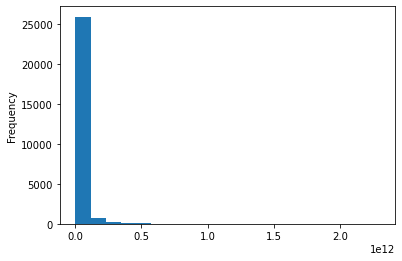

In [30]:
y.plot.hist(bins=20)

In [31]:
mask = (y > 0).values
mask

array([ True,  True,  True, ...,  True,  True,  True])

In [32]:
y_exp = np.log(list(y[mask]))
y_exp

array([23.69535911, 23.74263653, 23.71660473, ..., 22.81804382,
       22.67234514, 22.47012169])

<AxesSubplot:ylabel='Frequency'>

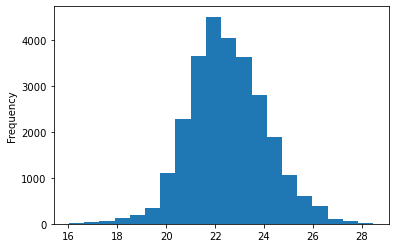

In [33]:
pd.Series(y_exp).plot.hist(bins=20)

# Train model

In [37]:
base_models = [
    LogExpModel(lgbm.sklearn.LGBMRegressor()),
    LogExpModel(XGBRegressor())
]
ensemble = EnsembleModel(base_models=base_models, bagging_fraction=0.7, models_cnt=20)

In [38]:
ensemble.fit(X, y)

KeyboardInterrupt: 